In [1]:
import numpy as np
import pandas as pd
import volpriceinference as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys
from functools import partial
import cdpm
from scipy import special

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

## Setup the True Parameters /  Simulation Parameters

In [4]:
vl.__version__

'0.0.28-py37_0'

In [5]:
kharpov = True

In [6]:
if kharpov:
    true_params = {'theta': 1.7680, 
               'pi': -10,
               'phi': -.40,
               'log_scale': np.log(252 * 1.564e-5),
                'logit_rho': special.logit(.8)
                }
    
    true_params['log_both'] = np.log(0.6475) + true_params['log_scale']
                
else:

#     Daily
     true_params ={'log_both': -4.45,
                   'log_scale': -3.48,
                   'logit_rho': 1.21,
                   'phi': -0.01,
                    'pi': -22.7, 
                   'theta': 0.28}
#     Weekly
#     true_params = {'log_both': -0.2768983372209973 + 0.805773558068805,
#                    'log_scale': 0.805773558068805,
#                    'rho': 0.6097218157104826,
#                    'phi': -0.8999999994952989,
#                    # Here I use the daily value.
#                    'pi': -.01,
#                    'theta': 2.6348432313374923}
    
time_dim = 10_000
sim_dim = 250
innov_dim = 250

In [7]:
bounds = {'pi': {'max': 0, 'min':-25, 'dim':32}, 'phi': {'max': 0, 'min':-.5, 'dim':4}, 
          'theta': {'max':2.5, 'min': 0, 'dim':12}}

In [8]:
total_true_params = true_params.copy()
total_true_params['psi'] = vl.compute_psi(log_scale=true_params['log_scale'], phi=true_params['phi'],
                                          theta=true_params['theta'])
total_true_params['beta'] = vl.compute_beta(logit_rho=true_params['logit_rho'], 
                                            log_scale=true_params['log_scale'], phi=true_params['phi'],
                                            pi=true_params['pi'],theta=true_params['theta'],
                                            psi=total_true_params['psi'])
total_true_params['gamma'] = vl.compute_gamma(log_scale=true_params['log_scale'], phi=true_params['phi'],
                                            pi=true_params['pi'],theta=true_params['theta'],
                                            psi=total_true_params['psi'], log_both=true_params['log_both'])
total_true_params['zeta'] = 1 - true_params['phi']**2                                           

In [9]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'psi': -3.44020732020312,
 'beta': 4.076658793315891,
 'gamma': 0.012227592917921713,
 'zeta': 0.84}

In [10]:
vl.compute_moments(psi=total_true_params['psi'], log_scale=true_params['log_scale'],
                   log_both=true_params['log_both'], logit_rho=true_params['logit_rho'],
                   pi=true_params['pi'], phi=true_params['phi'], theta=true_params['theta'])

{'return_mean': 0.02034864625098453,
 'return_var': 0.017873157660876243,
 'vol_mean': 0.012759894000000006,
 'vol_var': 0.0002514515751216002}

In [11]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

In [12]:
data.describe()

,vol,rtn
count,10000.000000,10000.000000
mean,0.011949,0.020569
std,0.014940,0.106517
min,0.000010,-0.778808
25%,0.001874,-0.024053
50%,0.006470,0.019797
75%,0.016449,0.065936
max,0.138966,0.724893


In [13]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'psi': -3.44020732020312,
 'beta': 4.076658793315891,
 'gamma': 0.012227592917921713,
 'zeta': 0.84}

In [14]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [15]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'psi': -3.44020732020312,
 'beta': 4.076658793315891,
 'gamma': 0.012227592917921713,
 'zeta': 0.84}

## We start by examining the distributions of simulated data

In [16]:
data.corr()

,vol,rtn
vol,1.000000,-0.016506
rtn,-0.016506,1.000000


In [17]:
data.head()

,vol,rtn
2000-01-01,0.021649,-0.113430
2000-01-02,0.031686,-0.106706
2000-01-03,0.045313,-0.232974
2000-01-04,0.019233,0.294610
2000-01-05,0.032124,0.110840


In [18]:
data.var()

vol    0.000223
rtn    0.011346
dtype: float64

In [19]:
vl.compute_vol_gmm(data.vol)

({'log_both': -6.013414370157847,
  'log_scale': -5.543095782785643,
  'logit_rho': 1.353954621907309},
            log_both  log_scale  logit_rho
 log_both   0.001238   0.000215  -0.001391
 log_scale  0.000215   0.000419  -0.000090
 logit_rho -0.001391  -0.000090   0.003724)

In [20]:
omega, omega_cov = vl.estimate_params(data)

In [21]:
total_est, total_cov = vl.estimate_params_strong_id(data, bounds=bounds)

In [22]:
omega

{'gamma': 0.012087485662306033,
 'beta': 4.059660620142231,
 'psi': -3.348842472853101,
 'zeta': 0.8475148772209923,
 'log_both': -6.013414370157847,
 'log_scale': -5.543095782785643,
 'logit_rho': 1.353954621907309}

In [23]:
omega_cov

,beta,gamma,log_both,log_scale,logit_rho,psi,zeta
beta,0.002812,-7.808185e-06,0.000000,0.000000,0.000000,-0.002159,0.000000
gamma,-0.000008,6.158860e-08,0.000000,0.000000,0.000000,0.000003,0.000000
log_both,0.000000,0.000000e+00,0.001238,0.000215,-0.001391,0.000000,0.000000
log_scale,0.000000,0.000000e+00,0.000215,0.000419,-0.000090,0.000000,0.000000
logit_rho,0.000000,0.000000e+00,-0.001391,-0.000090,0.003724,0.000000,0.000000
psi,-0.002159,2.653838e-06,0.000000,0.000000,0.000000,0.009033,0.000000
zeta,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000145


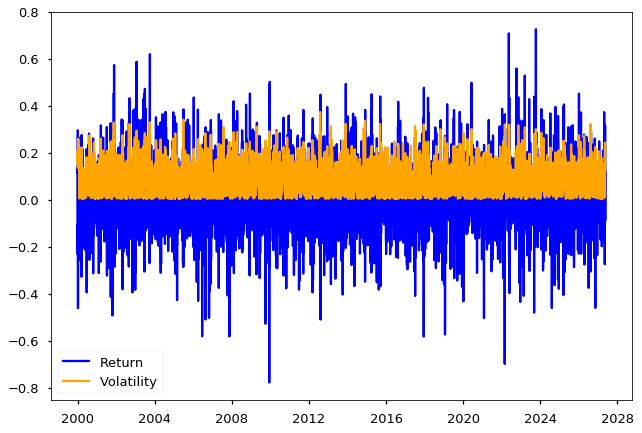

In [24]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return', color='blue')
ax1.plot(data.vol.apply(np.sqrt), label='Volatility', color='orange')

ax1.legend()

In [25]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,vol,rtn
vol,0.003671,-0.000106
rtn,-0.000106,0.011346


In [26]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'psi': -3.44020732020312,
 'beta': 4.076658793315891,
 'gamma': 0.012227592917921713,
 'zeta': 0.84}

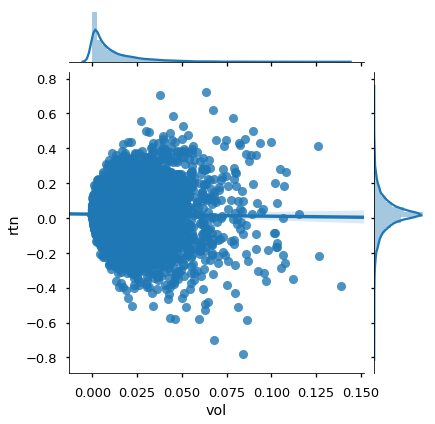

In [27]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [28]:
data.describe()

,vol,rtn
count,10000.000000,10000.000000
mean,0.011949,0.020569
std,0.014940,0.106517
min,0.000010,-0.778808
25%,0.001874,-0.024053
50%,0.006470,0.019797
75%,0.016449,0.065936
max,0.138966,0.724893


## I now estimate all of the parameters

In [29]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [30]:
vl.compute_init_constants(data.vol)

{'log_both': -5.9913975668636255,
 'log_scale': -5.544442014667419,
 'logit_rho': 1.3291921428369988}

In [31]:
data_arr = [vl.simulate_data(time_dim=time_dim, **true_params)  for _ in tqdm.tnrange(sim_dim)]

In [32]:
vl.compute_vol_gmm(data_arr[0].vol)

({'log_both': -5.9438420985231355,
  'log_scale': -5.52536967401893,
  'logit_rho': 1.3975585238772537},
            log_both  log_scale  logit_rho
 log_both   0.001255   0.000204  -0.001398
 log_scale  0.000204   0.000478  -0.000052
 logit_rho -0.001398  -0.000052   0.003699)

In [33]:
vol_params = pd.Series(true_params).loc[['log_both', 'log_scale', 'logit_rho']]

In [34]:
estimator = partial(vl.estimate_params_strong_id, bounds=bounds)

In [35]:
estimator(data_arr[0])

({'gamma': 0.011891394120392263,
  'beta': 4.10016282770427,
  'psi': -3.437612092212434,
  'zeta': 0.8309650436060574,
  'log_both': -5.9438420985231355,
  'log_scale': -5.52536967401893,
  'logit_rho': 1.3975585238772537,
  'phi': -0.4045042131449194,
  'pi': -7.168863081597253,
  'theta': 1.837469500219484},
                beta         gamma  log_both  log_scale  logit_rho       phi  \
 beta       0.003417 -8.673104e-06  0.000000   0.000000   0.000000       NaN   
 gamma     -0.000009  6.661323e-08  0.000000   0.000000   0.000000       NaN   
 log_both   0.000000  0.000000e+00  0.001255   0.000204  -0.001398       NaN   
 log_scale  0.000000  0.000000e+00  0.000204   0.000478  -0.000052       NaN   
 logit_rho  0.000000  0.000000e+00 -0.001398  -0.000052   0.003699       NaN   
 phi             NaN           NaN       NaN        NaN        NaN  0.000207   
 pi              NaN           NaN       NaN        NaN        NaN -0.074294   
 psi       -0.002763  3.652513e-06  0.000000   

In [36]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(estimator, data_arr),
                                      total=len(data_arr)))

In [37]:
def t_stats(x):
    mean = x.mean()
    cov = x.cov()
        
    return mean  / np.sqrt(np.diag(cov) / data.vol.size)

In [38]:
moment_data = pd.DataFrame([t_stats(vl.vol_moments(data.vol, log_both=true_params['log_both'],
                                                   logit_rho=true_params['logit_rho'], 
                                                   log_scale=true_params['log_scale'])) 
                            for data in tqdm.tqdm_notebook(data_arr)])

In [39]:
rf_names = ['log_scale', 'logit_rho', 'log_both', 'beta', 'gamma', 'zeta','psi']


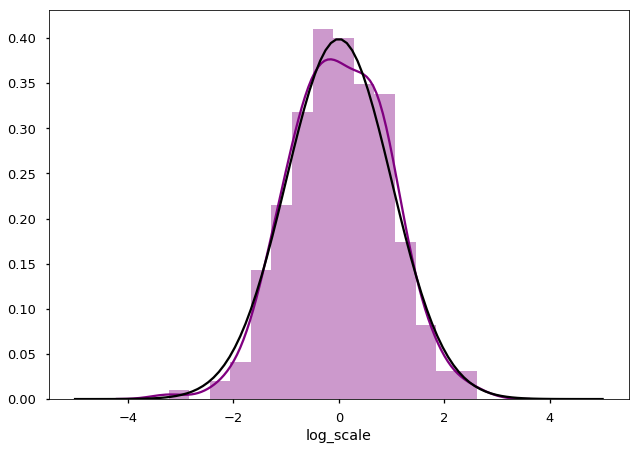

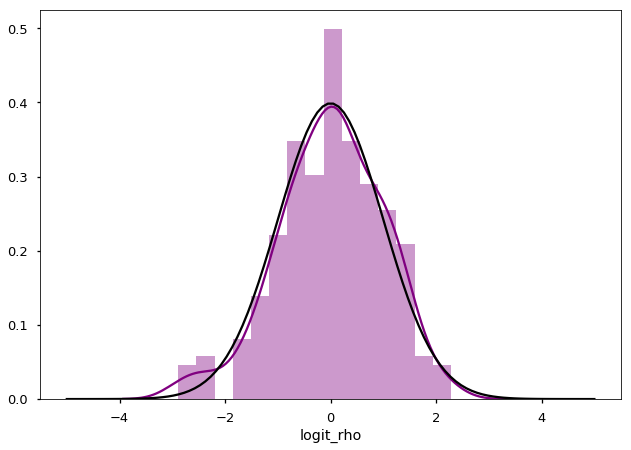

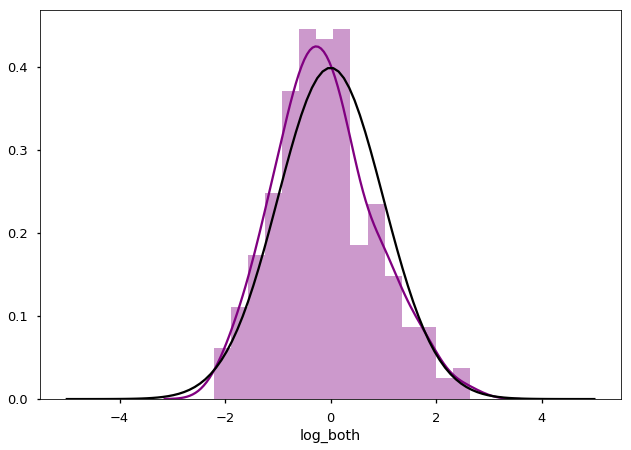

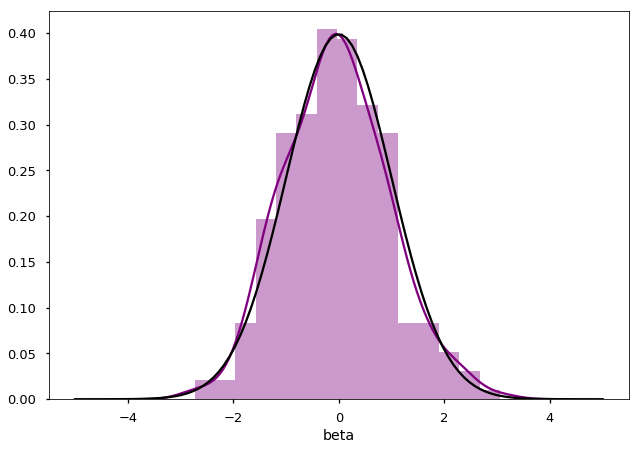

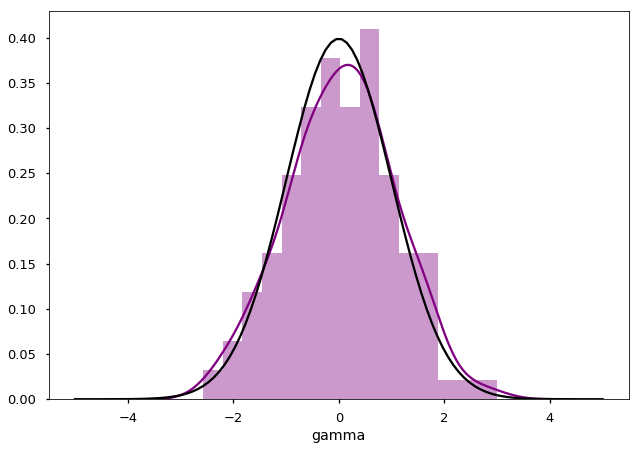

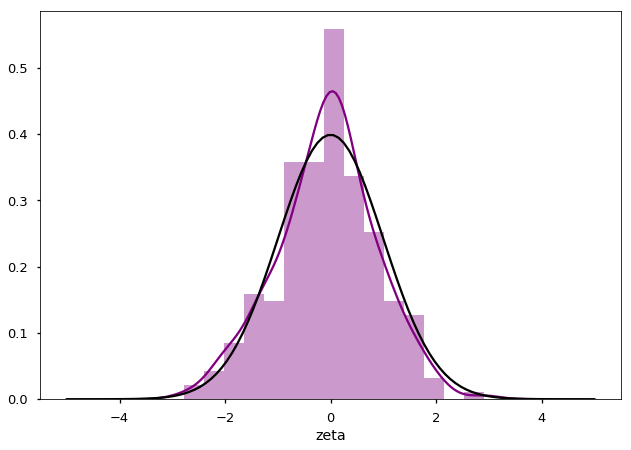

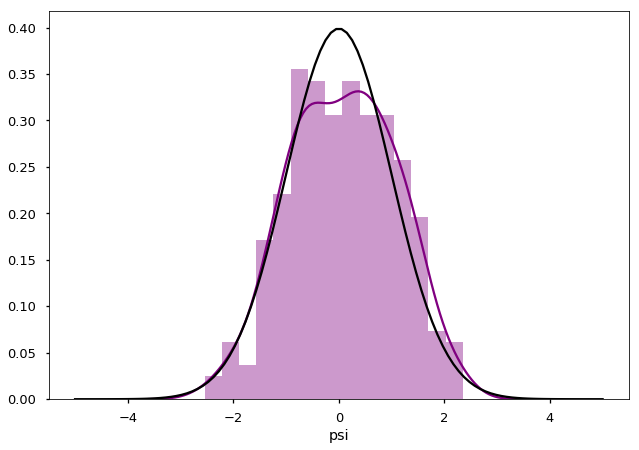

In [40]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in rf_names:
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([(est[name] - total_true_params[name]) / np.sqrt(cov.loc[name,name])
                  for est, cov in est_arr]).dropna(), ax=ax, bins=15, color='purple')
        ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
        ax.set_xlabel(name)
        if max(ax.get_xlim()) > 20:
            ax.set_xlim(-20, 20)

In [41]:
def link_function_t_stats(est):
    params = est[0]
    st_params = total_true_params['phi'], total_true_params['pi'], total_true_params['theta']
    rf_names = ['beta', 'gamma', 'log_both', 'log_scale', 'logit_rho', 'psi', 'zeta']
    link = vl.link_total(*st_params, params['beta'], params['gamma'], params['log_both'], params['log_scale'],
                        params['logit_rho'], params['psi'], params['zeta'])
    cov_in = est[1].loc[rf_names, rf_names]
    
    cov = vl._covariance_kernel(*st_params, *st_params, params['log_both'], params['log_scale'],
                                params['logit_rho'],cov_in , params['psi'])
    
    return link /  np.diag(cov)**.5

In [42]:
link_t_stats = np.array([link_function_t_stats(est) for est in tqdm.tqdm_notebook(est_arr)])

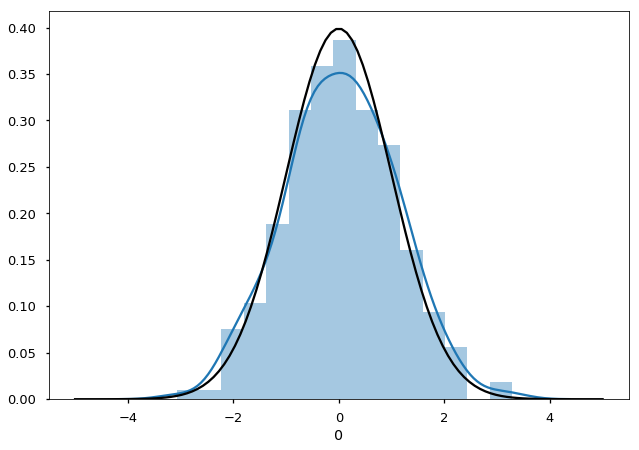

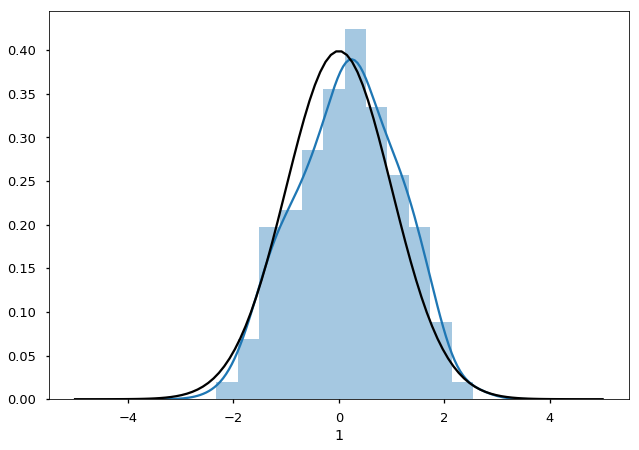

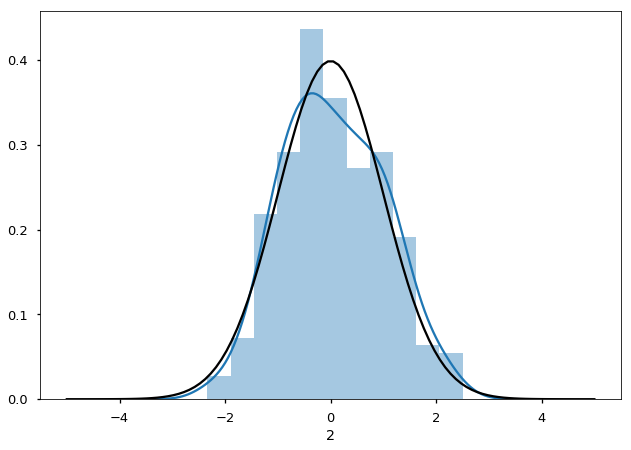

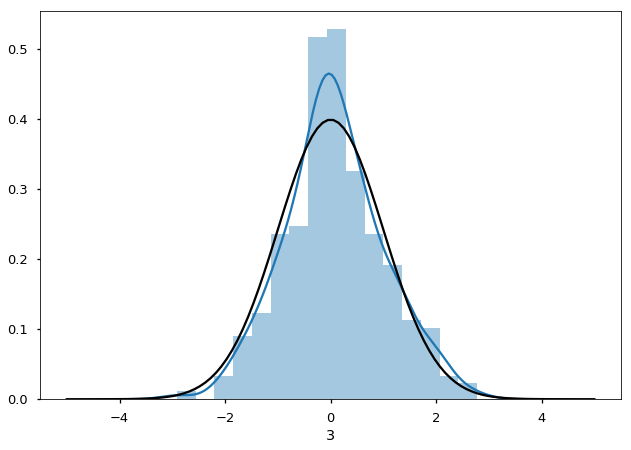

In [43]:
for key, col in enumerate(link_t_stats.T):
    fig, ax = mpl.pyplot.subplots()
    sns.distplot(col, ax=ax)
    ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')

    ax.set_xlabel(key)

In [44]:
bounds

{'pi': {'max': 0, 'min': -25, 'dim': 32},
 'phi': {'max': 0, 'min': -0.5, 'dim': 4},
 'theta': {'max': 2.5, 'min': 0, 'dim': 12}}

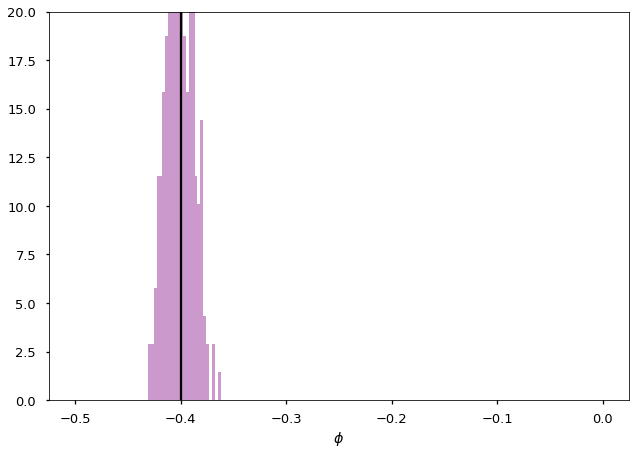

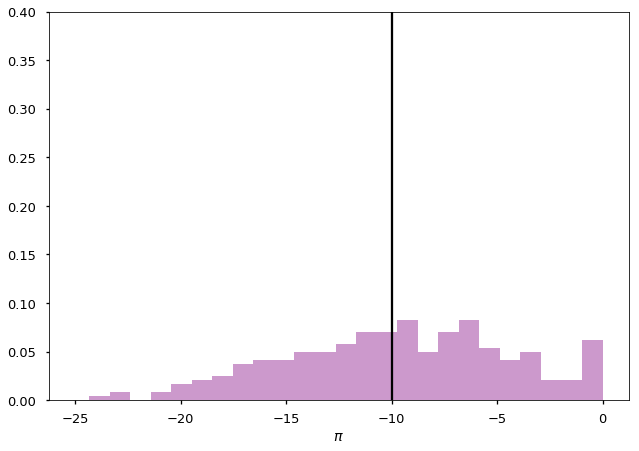

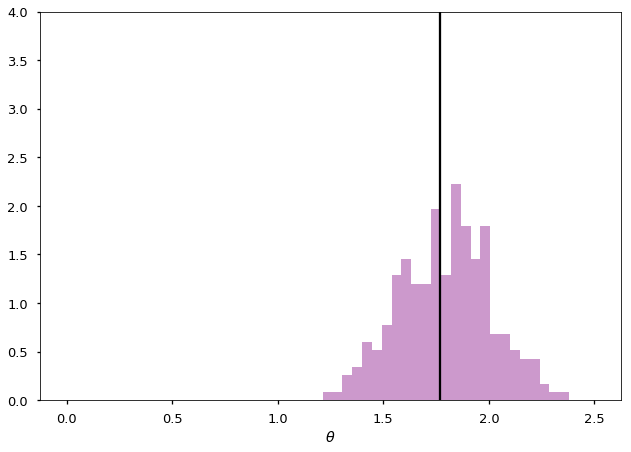

In [45]:
for name in ['phi', 'pi', 'theta']:
    fig, ax = mpl.pyplot.subplots()
    sns.distplot(pd.Series([est[name] 
                                for est, cov in est_arr]).dropna(), ax=ax, color='purple', bins=25,
                     kde=False, norm_hist=True)
    diff = (bounds[name]['max'] - bounds[name]['min'])
    ax.set_xlim([bounds[name]['min'] - .05 * diff ,  bounds[name]['max'] + .05 * diff])

    ax.set_ylim([0, 10 / diff])
    ax.axvline(true_params[name], color='black')
        
    ax.set_xlabel(f"$\{name}$")

    fig.savefig(f"../doc/figures/{name}_est_{innov_dim}_" + "{:.2f}".format(true_params['phi']).replace(
        ".", "_point_").replace("-", "minus_") + ".tmp.pdf", frameon=False, pad_inches=0,
                bbox_inches='tight', transparent=True)

# I now compute the robust conditional QLR statistic 

In [46]:
omega

{'gamma': 0.012087485662306033,
 'beta': 4.059660620142231,
 'psi': -3.348842472853101,
 'zeta': 0.8475148772209923,
 'log_both': -6.013414370157847,
 'log_scale': -5.543095782785643,
 'logit_rho': 1.353954621907309}

In [47]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [48]:
def compute_ar(params):
    param_est, param_cov = params
    names = vl.compute_names()
    omega = {name: val for name, val in param_est.items() if name not in names}
    omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
    
    true_prices=[true_params['phi'], true_params['pi'], true_params['theta']]
    
    return vl._qlr_in(prices=true_prices, omega=omega, omega_cov=omega_cov)

In [49]:
param_est, param_cov = est_arr[0]
names = vl.compute_names()
omega = {name: val for name, val in param_est.items() if name not in names}
omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
    
true_prices=[true_params['phi'], true_params['pi'], true_params['theta']]

In [50]:
with Pool(8) as pool:
    ar_results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_ar, est_arr),
                                                          total=len(est_arr)))))

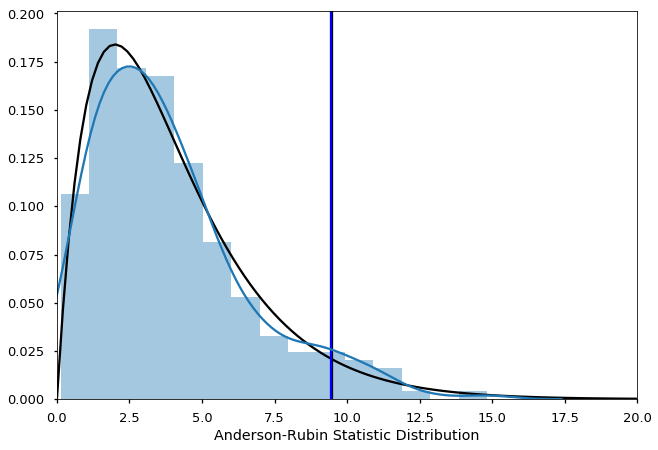

In [51]:
with pd.option_context('mode.use_inf_as_null', True):
    fig, ax = mpl.pyplot.subplots()       
    ax.plot(np.linspace(0,20,100), stats.chi2.pdf(np.linspace(0,20,100), df=4), color='black')

    ax.set_xlabel('Anderson-Rubin Statistic Distribution')
    ax.set_xlim(0, 20)
    ax.axvline(stats.chi2.ppf(df=4, q=.95), color='black')
    ax.axvline(np.percentile(ar_results, 95), color='blue')

    sns.distplot(ar_results, ax=ax)
    

In [52]:
np.mean(ar_results >= stats.chi2.ppf(df=4, q=.95))

0    0.048
dtype: float64

In [53]:
# compute_vals = partial(vl.compute_qlr_reject, true_prices=[true_params['phi'], true_params['pi'], 
#                                                            true_params['theta']],
#                       innov_dim=innov_dim, alpha=None, robust_quantile=True, bounds=bounds)

In [ ]:
# compute_vals = partial(vl.compute_qlr_reject, true_prices=[true_params['phi'], true_params['pi'], 
#                                                            true_params['theta']],
#                       innov_dim=100, alpha=None, robust_quantile=True, bounds=bounds)
# total=min(100, len(est_arr))
# with Pool(8) as pool:
#     results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_vals, 
#                                                                                     est_arr[:total]),
#                                                           total=total))))

In [56]:
# fig, ax = mpl.pyplot.subplots()
# sns.distplot(np.ravel(results.iloc[:,1:]), ax=ax, color='green')
# sns.distplot(np.ravel(ar_results), ax=ax, color='red')
# sns.distplot(np.ravel(results.iloc[:,0]), ax=ax, color='purple')

In [55]:
# robust_pit = cdpm.probability_integral_transform(evaluated_data = results.iloc[:,0].to_frame(),
#                                     reference_data=results.iloc[:,1:]).replace(np.inf, 1)
# standard_pit = stats.chi2.cdf(results.iloc[:,0], df=3)
# ar_pit = stats.chi2.cdf(ar_results, df=4)

In [57]:
# fig, ax = mpl.pyplot.subplots()
# cdpm.pit_plot(standard_pit, ax=ax, color='orange', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
#               label='standard')
# cdpm.pit_plot(robust_pit, ax=ax, color='blue', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
#               label='robust')
# cdpm.pit_plot(ar_pit, ax=ax, color='green', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
#               label='ar')
# ax.legend()
# fig.savefig('../doc/figures/asymptotic_dist_pitop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
#             frameon=False, pad_inches=0, bbox_inches='tight', transparent=True)

In [58]:
returnval = vl.compute_robust_rejection(est_arr, true_params, innov_dim=innov_dim, alpha=0.05, 
                                        robust_quantile=True, bounds=bounds)

In [59]:
np.percentile(returnval.qlr_stat, 95)

8.136709803794428

In [60]:
true_params['phi']

-0.4

In [68]:
if kharpov:
    filename = '../results/reject_prop_kharpov_{}_{}_{}.tmp.json'.format(innov_dim, true_params['phi'], 
                                                                         time_dim)
else:
    filename = '../results/reject_prop_{}_{}_{}.tmp.json'.format(innov_dim, true_params['phi'], time_dim)
    
returnval.to_json(filename)

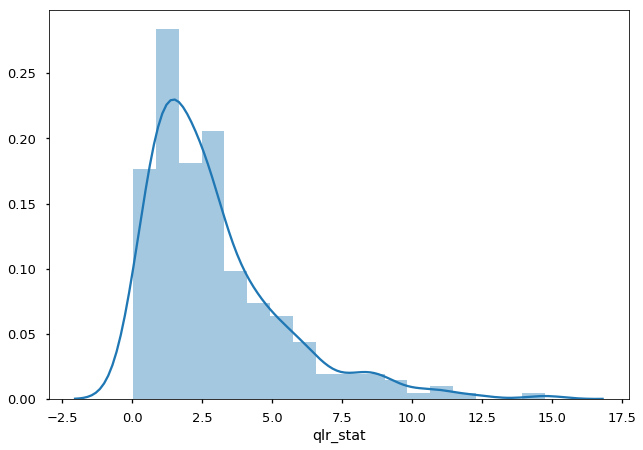

In [62]:
sns.distplot(returnval.qlr_stat)

In [63]:
returnval.query('robust_qlr_qauntile < 9.48').mean()

qlr_stat               2.918292
robust_qlr_qauntile    7.558717
robust                 0.064000
standard               0.060000
dtype: float64

In [64]:
returnval.mean()

qlr_stat               2.918292
robust_qlr_qauntile    7.558717
robust                 0.064000
standard               0.060000
dtype: float64

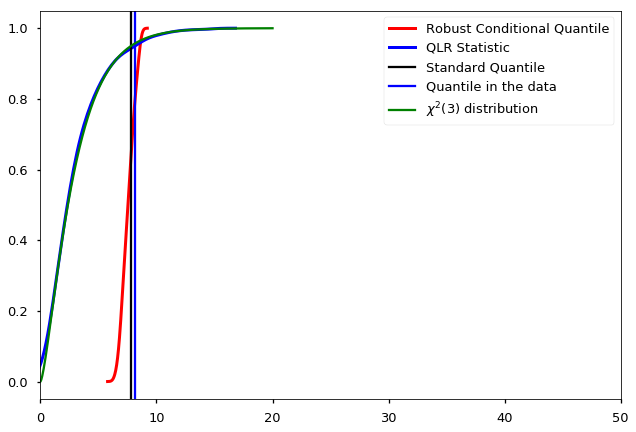

In [66]:
fig4, ax4 = mpl.pyplot.subplots()
try:
    sns.distplot(returnval.query('robust_qlr_qauntile > 0').robust_qlr_qauntile, 
                 kde_kws={"color": "red", "lw": 3, 'cumulative':True}, ax=ax4,hist=False, 
                 label='Robust Conditional Quantile')
           
except AttributeError:
    pass

sns.distplot(returnval.qlr_stat, hist=False, ax=ax4,kde_kws={"color": "blue", "lw": 3, 'cumulative':True},
      label='QLR Statistic')
ax4.axvline(stats.chi2.ppf(.95, df=3), color='black', label='Standard Quantile')
ax4.axvline(np.percentile(returnval.qlr_stat, 95),  color='Blue', label='Quantile in the data')

xvals = np.linspace(0, 20, 500)
ax4.plot(xvals, [stats.chi2.cdf(x, df=3) for x in xvals], color='green', label='$\chi^2(3)$ distribution')
ax4.set_xlim([0,50])
# ax4.set_ylim([0,.5])
ax4.set_xlabel("")
ax4.legend()
fig4.savefig('../doc/figures/reject_prop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
            frameon=False, pad_inches=0, bbox_inces='tight', transparent=True)